In [ ]:
import requests, zipfile, io

r = requests.get( 'https://github.com/suhasbn/DS402/blob/main/Lab5_dataset.zip?raw=true' )
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import os
import shutil
import re

base_dir = "Lab5_dataset/"

# Create training folder
files = os.listdir(base_dir)

# Moves all training yes images to yes folder, training no images to no folder
def train_maker(name):
  train_dir = f"{base_dir}/train/{name}"
  for f in files:
        search_object = re.search(name, f)
        if search_object:
          shutil.move(f'{base_dir}/{name}', train_dir)

train_maker("yes")
train_maker("no")

# Make the validation directories
os.makedirs("Lab5_dataset/val/yes")
os.makedirs("Lab5_dataset/val/no")

# Create validation folder

yes_train = base_dir + "train/yes/"
yes_val = base_dir + "val/yes/"
no_train = base_dir + "train/no/"
no_val = base_dir + "val/no/"

yes_files = os.listdir(yes_train)
no_files = os.listdir(no_train)

# This will put images from the two training folders
# into their respective validation folders
!bash -c 'mv Lab5_dataset/train/yes/Y{1..41}.jpg Lab5_dataset/val/yes'
!bash -c 'mv Lab5_dataset/train/no/{1..25}\ no.jpg Lab5_dataset/val/no'


In [ ]:
ls -l Lab5_dataset/train/* | wc -l;ls -l Lab5_dataset/val/* | wc -l

In [ ]:
#!rm -rf *

#CNN

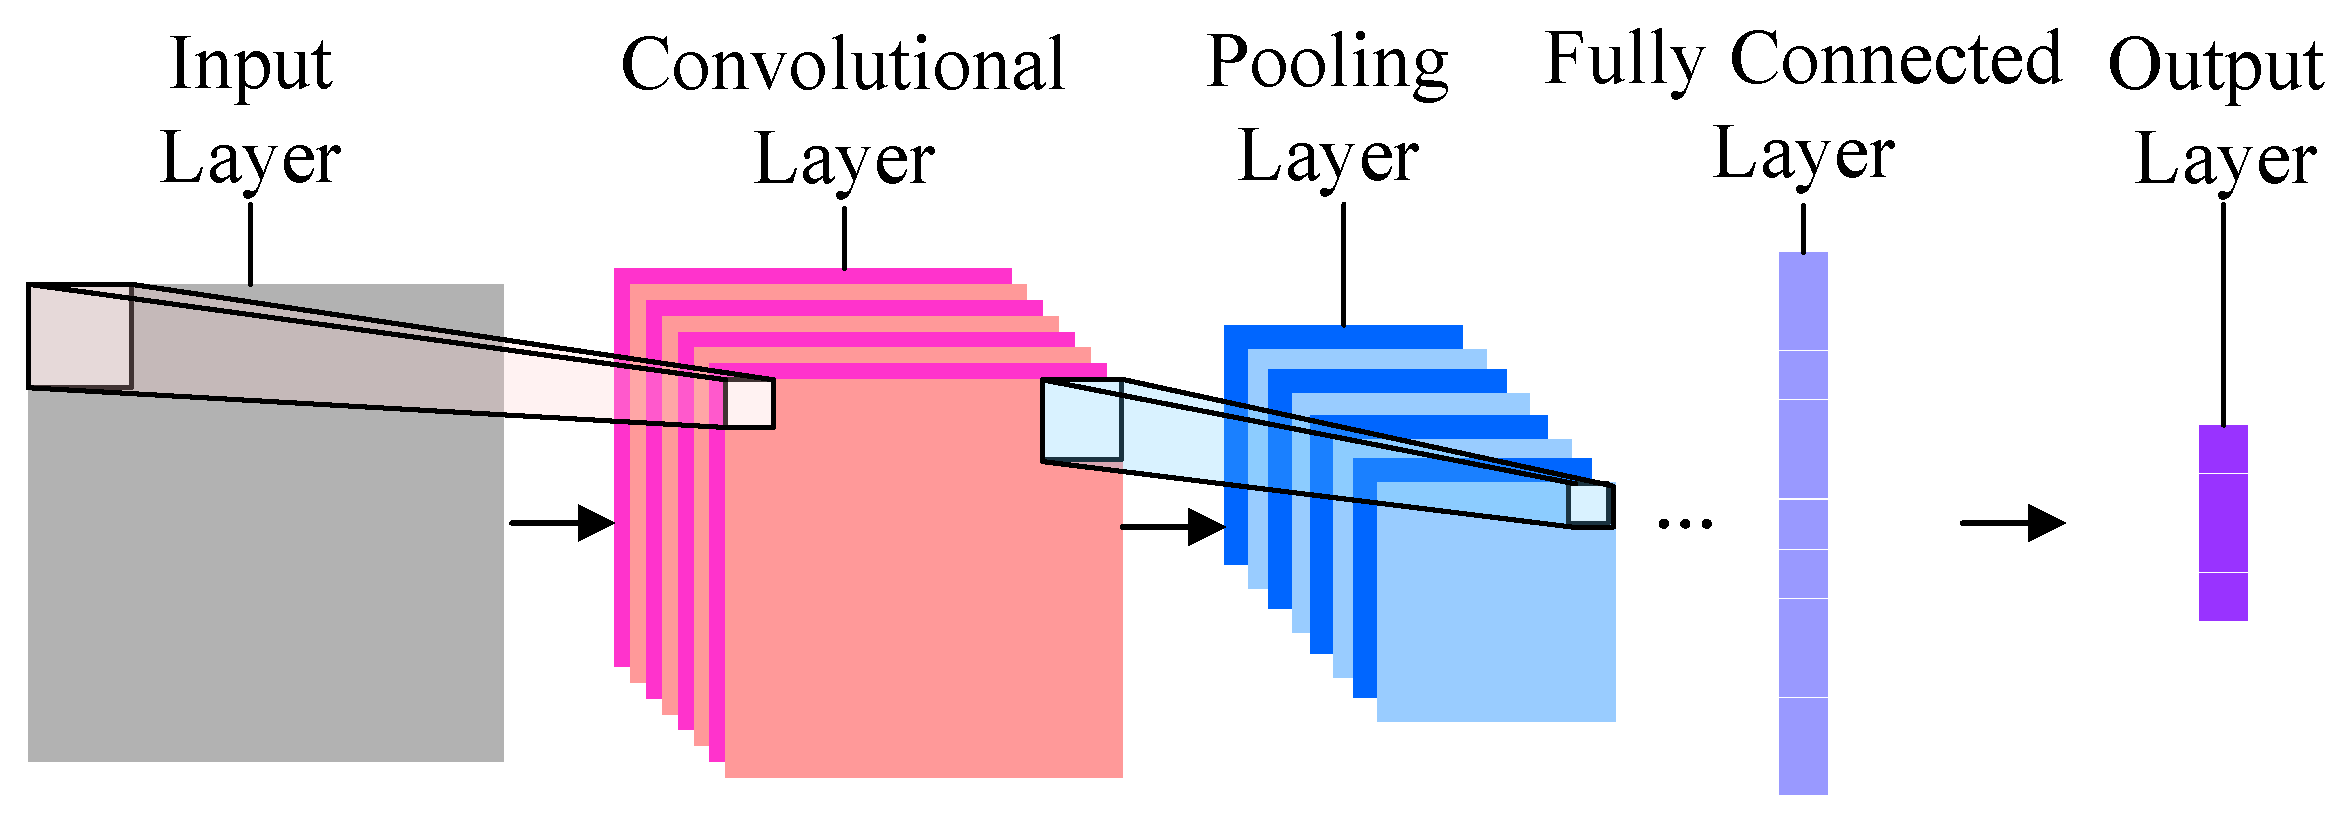

#Transfer Learning
There are two ways to choose a model for transfer learning.
1. It is possible to create a model from scratch for your own needs, save the model's parameters and structure, and then reuse the model later.

^ We did this till now!

2. The second way to implement transfer learning is to simply take an already existing model and reuse it, tuning its parameters and hyperparameters as you do so. In this instance, we will be using a pretrained model and modifying it. After you've decided what approach you want to use, choose a model (if you are using a pretrained model).

###Why are we doing it?
There are some advantages.

1. There is no need for an extremely large training dataset.

2. Huge computational power is not required. As we are using pre-trained weights and only have to learn the weights of the last few layers.


###Example
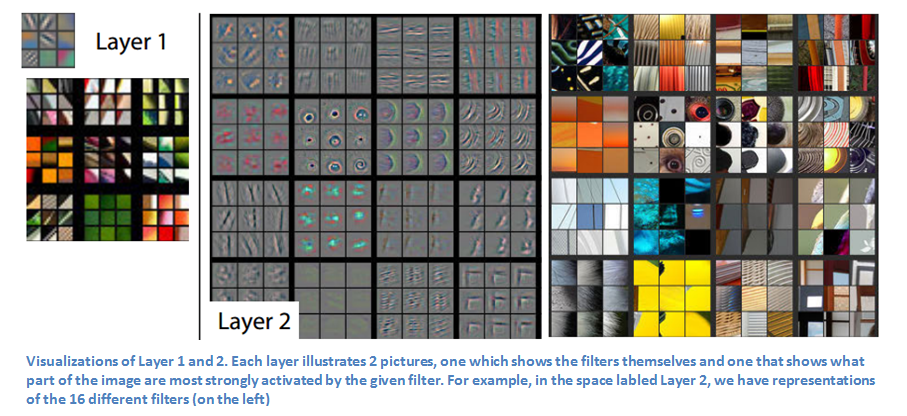

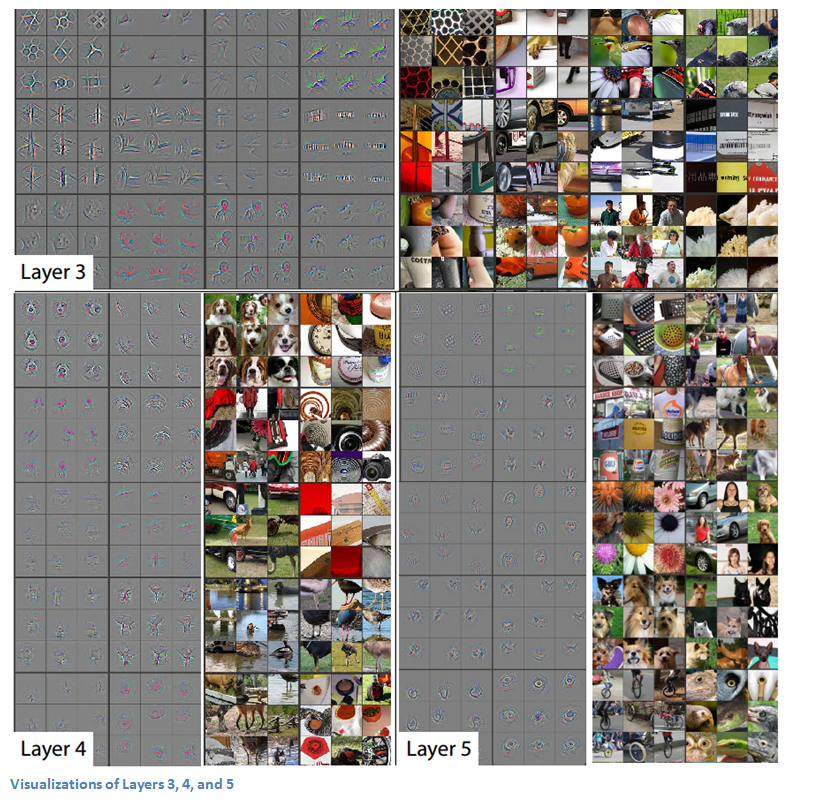

###Why does it work?
By using a pretrained network to do transfer learning, we are simply adding a few dense layers at the end of the pretrained network and learning what combination of these already learnt features help in recognizing the objects in our new dataset.

There are a variety of pretrained models that can be used in PyTorch. Some of the pretrained CNNs include:



*   AlexNet
*   CaffeResNet
*   Inception
*   The ResNet series (ResNet-18, ResNet-34, ResNet-51, ResNet-101, ResNet-1202, etc.)
*   The VGG series
*   GoogleNet, and many more!






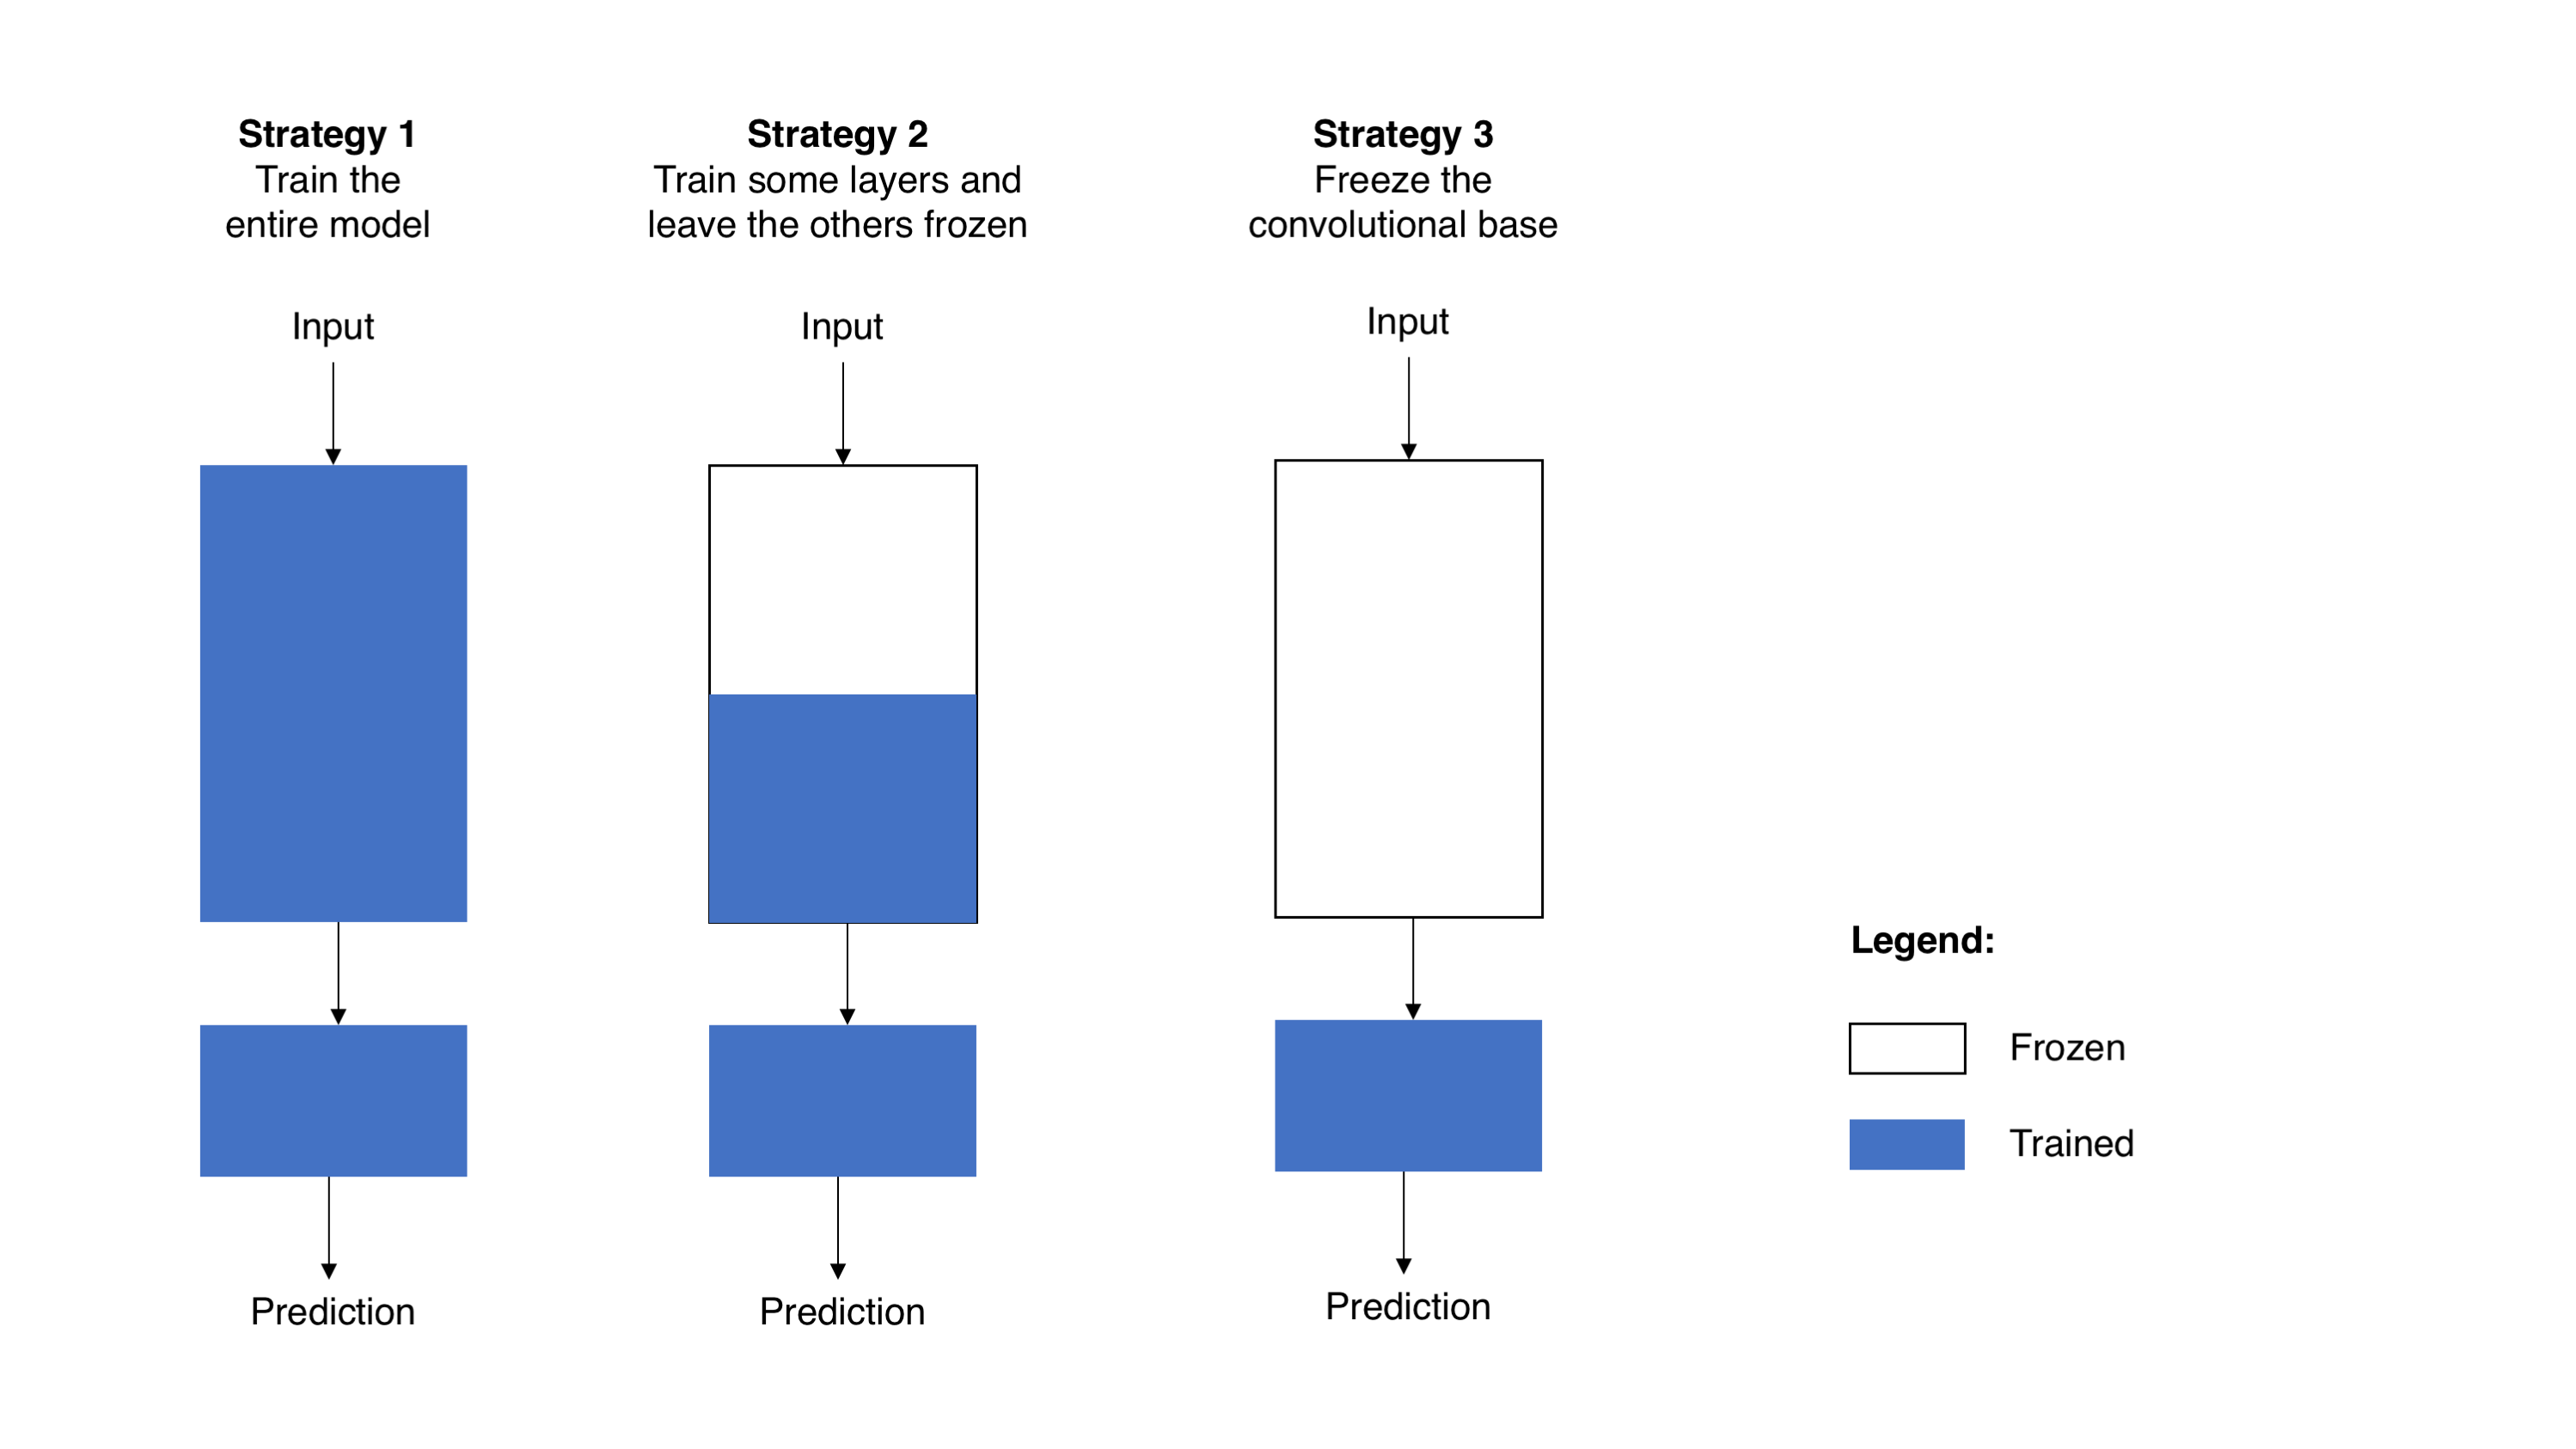

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [ ]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
# Set the directory for the data
data_dir = 'Lab5_dataset/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['train', 'val']}

In [ ]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=2)
              for x in ['train', 'val']}

In [ ]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


In [ ]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

In [ ]:
for name, child in res_mod.named_children():
    print(name)


In [ ]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)
visualize_model(base_model)
plt.show()

#Lab Assignment 5 (Due: 10/23/23, 11:59 PM EST) (5 pts)
Download the eye dataset from here : https://github.com/suhasbn/DS402/blob/main/Eye_Dataset.zip?raw=true

This dataset contains 4 classes:
1. eyes **closed**,
2. eyes looking **forward**,
3. eyes looking **left**, and
4. eyes looking **right**.

Q1. Split the data into train-val folders with 80% split (i.e. 600 images for each class in train and 150 images in test). (1 pts)

Q2. Use any Transfer Learning model from https://pytorch.org/vision/stable/models.html except what we used in Lab 5 (i.e. Except ResNet-34) and perform a 4 class classification. (1 pts)

Q3. Plot the confusion matrix (1 pt) and also find out the following values (1 pt): (2 pts)

a) TP, TN, FP, FN

b) F-1 score,

c) precision, and

d) recall.

Hint: You'll have to find out individually for each class and then do a weighted average based on the number of samples.

Q4. Plot the graph of training accuracy and validation accuracy (together) for all epochs. X-axis is the epoch, y-axis is the training acc and the val acc. (1 pts)
